In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_coverage = 'tme_data/sets/v2_maze/coverage/2'
os.chdir(path_coverage)

In [3]:
def read_text_file(file_path):
    with open(file_path, 'r') as f:
        return f.read()

In [4]:
def neg_eighty_check(matrix):
    result = True
    if(matrix.shape[0] == 80):
        result = False
    return result

In [5]:
def eighty_build(matrix):
    result = matrix
    if (neg_eighty_check(matrix)):
        number = 80-matrix.shape[0]
        temp_2 = np.full(number, matrix[-1])
        result = np.insert(result, -1, temp_2)
    return result

In [6]:
def min_mean_max_extraction(matrix):
    result = np.empty(3)
    result[0] = np.min(matrix)
    result[1] = np.mean(matrix)
    result[2] = np.max(matrix)
    return result

In [7]:
def min_median_max_extraction(matrix):
    result = np.empty(3)
    result[0] = np.min(matrix)
    result[1] = np.median(matrix)
    result[2] = np.max(matrix)
    return result

In [8]:
def matrix_splice(matrix, length):
    result_distance = matrix[:, 0]
    result_count = matrix[:, 0]
    result_distance_sum = matrix[:, 0]
    result_count_sum = matrix[:, 0]

    temp = matrix[:, 1:]
    loop = temp.shape[1]
    loop = loop / (length*2)
    loop = int(loop)

    for i in range(loop):
        num_1 = length
        num_2 = length*2
        temp_distance = temp[:, 0:num_1]
        temp_count = temp[:, num_1:num_2]
        temp_distance_sum = np.sum(temp_distance, axis=1)
        temp_count_sum = np.sum(temp_count, axis=1)
        result_distance=np.c_[result_distance, temp_distance]
        result_count=np.c_[result_count, temp_count]
        result_distance_sum = np.c_[result_distance_sum, temp_distance_sum]
        result_count_sum = np.c_[result_count_sum, temp_count_sum]
        temp = temp[:, num_2:]
        
    return result_distance, result_count, result_distance_sum, result_count_sum

In [9]:
def matrix_builder(matrix, distance_matrix):
    temp = []
    for i in range(80):
        temp.append(i*5)
    temp = np.array(temp)
    result = eighty_build(matrix[0][:, 1])
    result_2 = np.array(temp)
    result_2 = eighty_build_distance(distance_matrix[0][:,1:])
    index_array = []
    for i in range(len(matrix)):
        temp = matrix[i][:, 1]
        temp = eighty_build(temp)
        if(i < distance_matrix.shape[0]):
            temp_2 = distance_matrix[i][:,1:]
            temp_2 = eighty_build_distance(temp_2)
            if (temp[-1] > 0.90):
                test_passed = False
                start_value = -1
                index = 0
                count = 0
                for j in range(79):
                    if (np.abs(temp[j] - temp[j+1]) < 0.002):
                        if (temp[j+1] - start_value > 0.002):
                            index = j+1
                            start_value = temp[j+1]
                            count = 0
                        if (count >= 20):
                            break
                        count += 1
                    for x in range(len(temp_2[0])):
                        if (np.abs(temp_2[j][x] - temp_2[j+1][x]) > 5):
                            test_passed = True
                if(not test_passed):
                    result = np.c_[result, temp]
                    result_2 = np.c_[result_2, temp_2]
                    index_array.append(index)
    return result, result_2, index_array

In [10]:
def eighty_build_distance(matrix):
    result = matrix
    if (neg_eighty_check(matrix)):
        number = 80-matrix.shape[0]
        #temp_2 = np.full((number, 4), matrix[-1][:])
        #temp_2 = np.repeat(matrix[-1], number, axis=0)
        temp_2 = np.tile(matrix[-1], (number, 1))
        result = np.append(result, temp_2)
        result = result.reshape((80, -1))
    return result

In [11]:
def extraction(map_name, robot_num, eval_lower=1, eval_upper=-1):
    try: 
        os.chdir(f'../../{map_name}/coverage/{robot_num}')
    except:
        os.chdir(f'../../../{map_name}/coverage/{robot_num}')

    matrix_coverage_nearest = []
    matrix_coverage_greedy = []
    matrix_coverage_minPos = []
    matrix_coverage_combined = []
    matrix_coverage_coExplore = []

    for file in os.listdir():
        if file.endswith('.txt'):
            file_path =  f"{file}"
            if('nearest' in file_path):
                matrix_coverage_nearest.append(np.loadtxt(file_path))
            if('greedy' in file_path):
                matrix_coverage_greedy.append(np.loadtxt(file_path))
            if('minPos' in file_path):
                matrix_coverage_minPos.append(np.loadtxt(file_path))
            if('combined' in file_path):
                matrix_coverage_combined.append(np.loadtxt(file_path))
            if('coExplore' in file_path):
                matrix_coverage_coExplore.append(np.loadtxt(file_path))

    matrix_coverage_nearest = np.array(matrix_coverage_nearest)
    matrix_coverage_greedy = np.array(matrix_coverage_greedy)
    matrix_coverage_minPos = np.array(matrix_coverage_minPos)
    matrix_coverage_combined = np.array(matrix_coverage_combined)
    matrix_coverage_coExplore = np.array(matrix_coverage_coExplore)

    os.chdir(f'../../../{map_name}/distances/{robot_num}')

    matrix_distance_nearest = []
    matrix_distance_greedy = []
    matrix_distance_minPos = []
    matrix_distance_combined = []
    matrix_distance_coExplore = []

    for file in os.listdir():
        if file.endswith('.txt'):
            file_path =  f"{file}"
            if('nearest' in file_path):
                matrix_distance_nearest.append(np.loadtxt(file_path))
            if('greedy' in file_path):
                matrix_distance_greedy.append(np.loadtxt(file_path))
            if('minPos' in file_path):
                matrix_distance_minPos.append(np.loadtxt(file_path))
            if('combined' in file_path):
                matrix_distance_combined.append(np.loadtxt(file_path))
            if('coExplore' in file_path):
                matrix_distance_coExplore.append(np.loadtxt(file_path))

    matrix_distance_nearest = np.array(matrix_distance_nearest)
    matrix_distance_greedy = np.array(matrix_distance_greedy)
    matrix_distance_minPos = np.array(matrix_distance_minPos)
    matrix_distance_combined = np.array(matrix_distance_combined)
    matrix_distance_coExplore = np.array(matrix_distance_coExplore)

    nearest_c_plot, nearest_d_plot, nearest_time_taken = matrix_builder(matrix_coverage_nearest, matrix_distance_nearest)
    greedy_c_plot, greedy_d_plot, greedy_time_taken = matrix_builder(matrix_coverage_greedy, matrix_distance_greedy)
    minPos_c_plot, minPos_d_plot, minPos_time_taken = matrix_builder(matrix_coverage_minPos, matrix_distance_minPos)
    combined_c_plot, combined_d_plot, combined_time_taken = matrix_builder(matrix_coverage_combined, matrix_distance_combined)
    coExplore_c_plot, coExplore_d_plot, coExplore_time_taken = matrix_builder(matrix_coverage_coExplore, matrix_distance_coExplore)

    time_values_nearest = min_median_max_extraction(nearest_time_taken[eval_lower:eval_upper])
    time_values_greedy = min_median_max_extraction(greedy_time_taken[eval_lower:eval_upper])
    time_values_combined = min_median_max_extraction(combined_time_taken[eval_lower:eval_upper])
    time_values_minPos = min_median_max_extraction(minPos_time_taken[eval_lower:eval_upper])
    time_values_coExplore = min_median_max_extraction(coExplore_time_taken[eval_lower:eval_upper])
    time_values = [time_values_nearest, time_values_greedy, time_values_minPos, time_values_combined, time_values_coExplore]

    nearest_median = np.median(nearest_c_plot[:, eval_lower:eval_upper], axis=1)
    greedy_median = np.median(greedy_c_plot[:, eval_lower:eval_upper], axis=1)
    minPos_median = np.median(minPos_c_plot[:, eval_lower:eval_upper], axis=1)
    combined_median = np.median(combined_c_plot[:, eval_lower:eval_upper], axis=1)
    coExplore_median = np.median(coExplore_c_plot[:, eval_lower:eval_upper], axis=1)

    nearest_d, nearest_c, nearest_c_sum, nearest_d_sum = matrix_splice(nearest_d_plot, 5)
    greedy_d, greedy_c, greedy_c_sum, greedy_d_sum = matrix_splice(greedy_d_plot, 5)
    combined_d, combined_c, combined_c_sum, combined_d_sum = matrix_splice(combined_d_plot, 5)
    minPos_d, minPos_c, minPos_c_sum, minPos_d_sum = matrix_splice(minPos_d_plot, 5)
    coExplore_d, coExplore_c, coExplore_c_sum, coExplore_d_sum = matrix_splice(coExplore_d_plot, 5)

    nearest_c_sum_median = np.median(nearest_c_sum[:, 1:-1], axis=1)
    greedy_c_sum_median = np.median(greedy_c_sum[:, 1:-1], axis=1)
    minPos_c_sum_median = np.median(minPos_c_sum[:, 1:-1], axis=1)
    combined_c_sum_median = np.median(combined_c_sum[:, 1:-1], axis=1)
    coExplore_c_sum_median = np.median(coExplore_c_sum[:, 1:-1], axis=1)

    nearest_d_sum_median = np.median(nearest_d_sum[:, 1:-1], axis=1)
    greedy_d_sum_median = np.median(greedy_d_sum[:, 1:-1], axis=1)
    minPos_d_sum_median = np.median(minPos_d_sum[:, 1:-1], axis=1)
    combined_d_sum_median = np.median(combined_d_sum[:, 1:-1], axis=1)
    coExplore_d_sum_median = np.median(coExplore_d_sum[:, 1:-1], axis=1)

    result_a = [nearest_median, greedy_median, minPos_median, combined_median, coExplore_median]
    result_b = time_values
    result_c = [nearest_c_sum_median, greedy_c_sum_median, minPos_c_sum_median, combined_c_sum_median, coExplore_c_sum_median]
    result_d = [nearest_d_sum_median, greedy_d_sum_median, minPos_d_sum_median, combined_d_sum_median, coExplore_d_sum_median]

    return result_a, result_b, result_c, result_d


In [12]:
marty_2_a, marty_2_b, marty_2_c, marty_2_d = extraction('marty', 2)
marty_3_a, marty_3_b, marty_3_c, marty_3_d = extraction('marty', 3)
marty_4_a, marty_4_b, marty_4_c, marty_4_d = extraction('marty', 4)
marty_5_a, marty_5_b, marty_5_c, marty_5_d = extraction('marty', 5)

map_2_a, map_2_b, map_2_c, map_2_d = extraction('map_3', 2)
map_3_a, map_3_b, map_3_c, map_3_d = extraction('map_3', 3)
map_4_a, map_4_b, map_4_c, map_4_d = extraction('map_3', 4)
map_5_a, map_5_b, map_5_c, map_5_d = extraction('map_3', 5)

maze_2_a, maze_2_b, maze_2_c, maze_2_d = extraction('v2_maze', 2)
maze_3_a, maze_3_b, maze_3_c, maze_3_d = extraction('v2_maze', 3)
maze_4_a, maze_4_b, maze_4_c, maze_4_d = extraction('v2_maze', 4)
maze_5_a, maze_5_b, maze_5_c, maze_5_d = extraction('v2_maze', 5)

In [13]:
def mid_compilation(matrix1, matrix2, matrix3, matrix4, index):
    result = [matrix1[index][2], matrix2[index][2], matrix3[index][2], matrix4[index][2]]
    return result

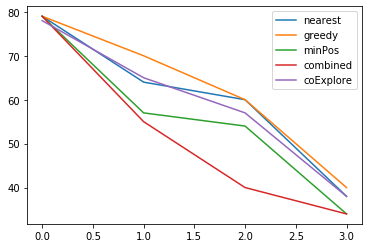

In [14]:
marty_nearest = mid_compilation(marty_2_b, marty_3_b, marty_4_b, marty_5_b, 0)
marty_greedy = mid_compilation(marty_2_b, marty_3_b, marty_4_b, marty_5_b, 1)
marty_minPos = mid_compilation(marty_2_b, marty_3_b, marty_4_b, marty_5_b, 2)
marty_combined = mid_compilation(marty_2_b, marty_3_b, marty_4_b, marty_5_b, 3)
marty_coExplore = mid_compilation(marty_2_b, marty_3_b, marty_4_b, marty_5_b, 4)

plt.plot(marty_nearest, label='nearest')
plt.plot(marty_greedy, label='greedy')
plt.plot(marty_minPos, label='minPos')
plt.plot(marty_combined, label='combined')
plt.plot(marty_coExplore, label='coExplore')
plt.legend()
plt.show()

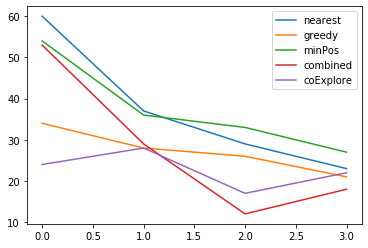

In [15]:
map_nearest = mid_compilation(map_2_b, map_3_b, map_4_b, map_5_b, 0)
map_greedy = mid_compilation(map_2_b, map_3_b, map_4_b, map_5_b, 1)
map_minPos = mid_compilation(map_2_b, map_3_b, map_4_b, map_5_b, 2)
map_combined = mid_compilation(map_2_b, map_3_b, map_4_b, map_5_b, 3)
map_coExplore = mid_compilation(map_2_b, map_3_b, map_4_b, map_5_b, 4)

plt.plot(map_nearest, label='nearest')
plt.plot(map_greedy, label='greedy')
plt.plot(map_minPos, label='minPos')
plt.plot(map_combined, label='combined')
plt.plot(map_coExplore, label='coExplore')
plt.legend()
plt.show()

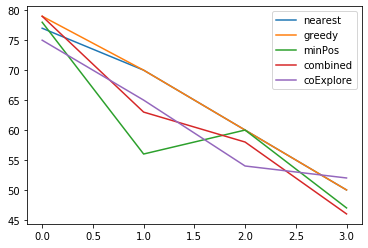

In [18]:
maze_nearest = mid_compilation(maze_2_b, maze_3_b, maze_4_b, maze_5_b, 0)
maze_greedy = mid_compilation(maze_2_b, maze_3_b, maze_4_b, maze_5_b, 1)
maze_minPos = mid_compilation(maze_2_b, maze_3_b, maze_4_b, maze_5_b, 2)
maze_combined = mid_compilation(maze_2_b, maze_3_b, maze_4_b, maze_5_b, 3)
maze_coExplore = mid_compilation(maze_2_b, maze_3_b, maze_4_b, maze_5_b, 4)

plt.plot(maze_nearest, label='nearest')
plt.plot(maze_greedy, label='greedy')
plt.plot(maze_minPos, label='minPos')
plt.plot(maze_combined, label='combined')
plt.plot(maze_coExplore, label='coExplore')
plt.legend()
plt.show()